# General notebook for testing purpose

Dashboard: https://developer.riotgames.com/  
Region endpoints: https://developer.riotgames.com/regional-endpoints.html  
Full reference: https://developer.riotgames.com/api-methods/

## Imports
### General imports

In [10]:
import sys
import pandas as pd

%matplotlib inline
import matplotlib
matplotlib.style.use("ggplot")

### Specific imports

In [50]:
repo_path = "D:\Documents\GitHub\league-of-legends"

if not repo_path in sys.path:
    sys.path.append(repo_path)
    
import lib_plots; lib_plots = reload(lib_plots)
import lib_api; lib_api = reload(lib_api)
import lib_custom; lib_custom = reload(lib_custom)

## Parameters & API key

In [32]:
region = "euw1"
summoner_name = "Cyrlop"
api_key = "RGAPI-6c6c5b47-39f8-4490-91b6-6e0ff6ecf95f"
summoner_names = ["Cyrlop", "Helluin", "leag"]
league_id = "98fcdbf0-fc9e-11e7-972b-c81f66dacb22"

In [14]:
api_works = lib_api.test_api_key(api_key)

API request successful


## Summoners

In [15]:
json_summ_list = [lib_api.get_summoner_data(region, summoner_name, api_key) for summoner_name in summoner_names]

In [16]:
df_summoners = pd.DataFrame(json_summ_list).set_index("name")
df_summoners

,accountId,id,profileIconId,revisionDate,summonerLevel
name,,,,,
Cyrlop,29238184,24732627,3226,1520077158000,65
Helluin,21603599,376152,19,1520074822000,60
leaG,239556,233829,661,1495764755000,30


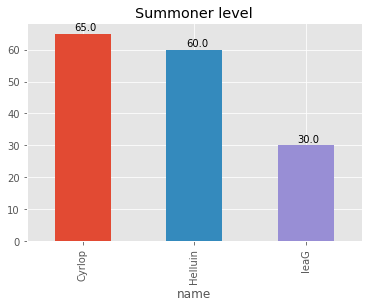

In [17]:
ax = df_summoners["summonerLevel"].plot.bar(title="Summoner level")
ax = lib_plots.label_bars(ax, perc=False)
ax

## Leagues

In [26]:
json_league_list = [lib_api.get_summoner_league(summoner_id, region, api_key) for summoner_id in df_summoners["id"]]

In [28]:
leagues = []
for l in json_league_list:
    for e in l:
        leagues.append(e)
df_leagues = pd.DataFrame(leagues).set_index(["playerOrTeamName","queueType"])
df_leagues["ratio"] = (df_leagues["wins"]/(df_leagues["losses"]+df_leagues["wins"]))*100
df_leagues["ratio"] = df_leagues["ratio"].apply(round, ndigits=2)
df_leagues

,,freshBlood,hotStreak,inactive,leagueId,leagueName,leaguePoints,losses,playerOrTeamId,rank,tier,veteran,wins,ratio
playerOrTeamName,queueType,,,,,,,,,,,,,
Cyrlop,RANKED_SOLO_5x5,False,False,False,98fcdbf0-fc9e-11e7-972b-c81f66dacb22,Zed's Spellswords,82,49,24732627,IV,GOLD,False,49,50.0
Helluin,RANKED_SOLO_5x5,False,False,False,adf0deb0-fa93-11e7-964f-c81f66dd0e0d,Trundle's Spellswords,0,76,376152,I,GOLD,True,76,50.0


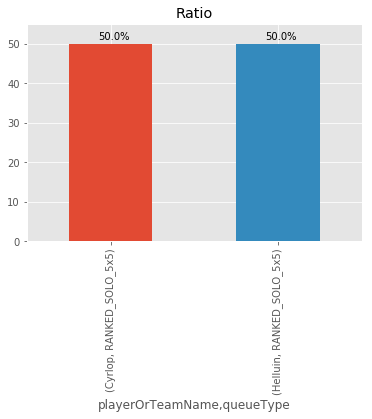

In [30]:
ax = df_leagues["ratio"].plot.bar(title="Ratio", ylim=(0,55))
ax = lib_plots.label_bars(ax, perc=True)
ax

## Start testing theory: Pseudo syntax

### Get as much data as possible

In [38]:
league_data = lib_api.get_league_data(league_id, region, api_key)

In [44]:
league_list_for_df = []

for entry in league_data["entries"]:
    league_list_for_df.append({
        "Wins": entry["wins"],
        "Losses": entry["losses"],
        "Pseudo": entry["playerOrTeamName"],
        "Rank": entry["rank"],
        "Ratio": (float(entry["wins"])/(float(entry["losses"])+float(entry["wins"])))*100
    })

df_league_players = pd.DataFrame(league_list_for_df)
df_league_players.head()

,Losses,Pseudo,Rank,Ratio,Wins
0,8,Yergi,V,52.941176,9
1,113,Adaptoe,IV,52.719665,126
2,18,Da 3p1c 0n3,I,43.750000,14
3,69,LittleHawk02,II,48.120301,64
4,62,crYs0,III,49.180328,60


### Rank all pseudos

In [51]:
df_league_players["Pseudo_score"] = df_league_players["Pseudo"].apply(lib_custom.rate_pseudo)
df_league_players.head()

,Losses,Pseudo,Rank,Ratio,Wins,Pseudo_score
0,8,Yergi,V,52.941176,9,1.00
1,113,Adaptoe,IV,52.719665,126,1.00
2,18,Da 3p1c 0n3,I,43.750000,14,0.50
3,69,LittleHawk02,II,48.120301,64,0.50
4,62,crYs0,III,49.180328,60,0.25


### Check if higher ranked pseudo win more

In [53]:
df_league_players_grouped = df_league_players.groupby("Pseudo_score").mean()
df_league_players_grouped

,Losses,Ratio,Wins
Pseudo_score,,,
0.250,34.764706,54.434302,38.117647
0.375,54.500000,49.087118,54.750000
0.500,40.815385,52.147298,41.430769
0.750,39.666667,55.627727,42.333333
1.000,38.035714,49.823866,37.776786


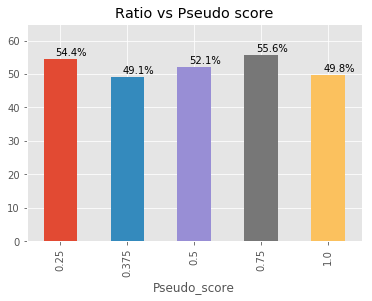

In [57]:
ax = df_league_players_grouped["Ratio"].plot.bar(title="Ratio vs Pseudo score", ylim=(0,65))
ax = lib_plots.label_bars(ax, perc=True)
ax